[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1tayKZyBpQX0nswLEjX6f7smUwvHii6D9?usp=sharing)

# Text classification - Instacart Dataset

In [2]:
from huggingface_hub import login
# login('xxxx', add_to_git_credential=True)


In [3]:
import numpy as np
from datasets import load_dataset
from datasets import Dataset
from datasets import DatasetDict
import pandas as pd
import matplotlib.pyplot as plt
from transformers import Trainer, TrainingArguments
import transformers
import re
import torch
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import Trainer
from sklearn.metrics import accuracy_score


from create_set import create_dataset, create_number_labs


In [4]:
import torch.nn as nn
from transformers import AutoModel

class PosModel(nn.Module):
    def __init__(self):
        super(PosModel, self).__init__()
        
        self.base_model = AutoModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(0.5)
        self.linear = nn.Linear(768, 1) # output features from bert is 768 and 2 is ur number of labels
        
    def forward(self, input_ids, attn_mask):
        outputs = self.base_model(input_ids, attention_mask=attn_mask)
        print('op shape:', outputs[0].shape)
        # You write you new head here
        outputs = self.dropout(outputs[0])
        outputs = self.linear(outputs)
        
        return outputs

# model = PosModel()
# model.to('cuda')

In [5]:
df_csv = pd.read_csv('../scrape/test_food_bev_alc.csv')
unq_id = df_csv.typeID.unique()
print([fnc(unq_id) for fnc in [len, max]])
df_csv.drop(columns=['typeID', 'link'], inplace=True)
df_csv.rename(columns={"product": "text"}, inplace=True)
df_csv.head()

[2244, 2327]


,text,label
0,New Belgium Brewing Fat Tire Ale12 fl oz,alcohol/beer/ales/amber red ale
1,"Yuengling Beer, Traditional Lager, 24 Pack12 f...",alcohol/beer/ales/amber red ale
2,George Killian's Irish Red Lager Beer12 fl oz,alcohol/beer/ales/amber red ale
3,"Dragon's Milk Crimson Keep, Bourbon Barrel-Age...",alcohol/beer/ales/amber red ale
4,Smithwick's Red Ale Beer14.9 fl oz,alcohol/beer/ales/amber red ale


In [6]:
id_chk = create_number_labs(df_csv, 'label', 7)

In [7]:
print(df_csv.base_label.max())
df_csv.head()


56399


,text,label,lab_0,lab_1,lab_2,lab_3,lab_4,lab_5,base_label
0,New Belgium Brewing Fat Tire Ale12 fl oz,alcohol/beer/ales/amber red ale,0,1,0,0,0,0,2401
1,"Yuengling Beer, Traditional Lager, 24 Pack12 f...",alcohol/beer/ales/amber red ale,0,1,0,0,0,0,2401
2,George Killian's Irish Red Lager Beer12 fl oz,alcohol/beer/ales/amber red ale,0,1,0,0,0,0,2401
3,"Dragon's Milk Crimson Keep, Bourbon Barrel-Age...",alcohol/beer/ales/amber red ale,0,1,0,0,0,0,2401
4,Smithwick's Red Ale Beer14.9 fl oz,alcohol/beer/ales/amber red ale,0,1,0,0,0,0,2401


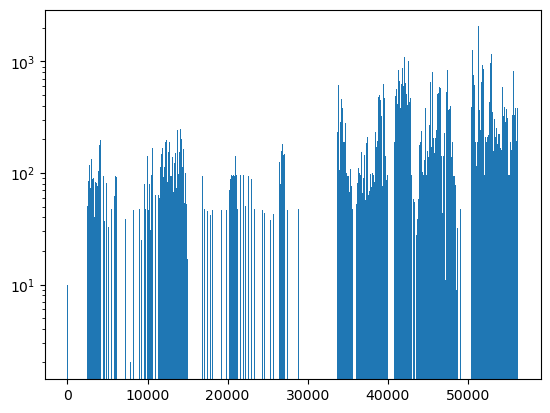

In [8]:
binw = 100
plt.hist(df_csv.base_label, bins=np.arange(0, df_csv.base_label.max(), binw)-.5)
plt.yscale('log')

In [9]:
dset = create_dataset(df_csv)
df_csv['orig_lab'] = df_csv['label'].copy()
df_csv['label'] = df_csv['base_label'].copy()
# [len(ddfs['product']) for ddfs in dict_dfs]
# len(dict_dfs)

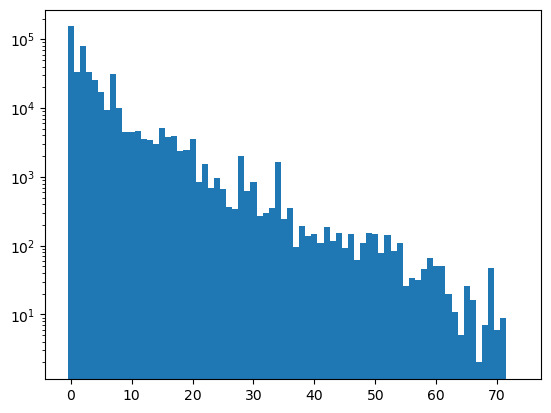

In [10]:
plt.hist(id_chk.label_array.flatten(), bins = np.arange(0, 75)-.5)
plt.yscale('log')

In [11]:
(df_csv['label'].max()-df_csv['label'].min())

56399

In [12]:
# df_csv['label'] = ((df_csv['label']-df_csv['label'].min())*100000/(df_csv['label'].max()-df_csv['label'].min())).astype(int)
prod = dset.get_train_val_test([.9,.09,.01])


## Overview of Instacart Dataset

In [13]:
prod.set_format('pandas')
df = prod['train'][:]
df.sample(frac=1 ,random_state=1).head(10)

,text,label,lab_0,lab_1,lab_2,lab_3,lab_4,lab_5,base_label,orig_lab
58240,"Welch's Fruit Snacks, Island Fruits0.8 oz",55860,2,7,15,6,0,0,55860,food/pantry/snacks/gummy fruit snacks
15680,Kontos Tandoori Naan10 ct,35084,2,0,4,2,0,0,35084,food/baked goods/flatbreads/naan
37346,Garlic Scapes (Whistles)1 lb,42590,2,3,1,28,8,2,42590,food/fresh produce/fresh vegetables/root veget...
31865,Agroexport Medium Hass Avocadoseach,40950,2,3,0,2,5,0,40950,food/fresh produce/fresh fruit/avocados/hass a...
41514,Alpha Bac'n Scramble Breakfast Burrito5.5 oz,43904,2,4,2,0,0,0,43904,food/frozen food/frozen breakfast/frozen break...
46265,"Franklin's Teleme Seitan, Chik'n8 oz",48363,2,6,1,0,0,0,48363,food/meat alternatives/seitan
57260,"Chex Mix Snack Mix, Traditional, Savory, Singl...",56007,2,7,15,9,0,0,56007,food/pantry/snacks/mixed dry snacks
17448,Sargento Reserve Series™ Shaved Fourteen-Month...,38367,2,1,0,48,0,0,38367,food/dairy/cheese/parmesan
52733,"Natierra Corn, Organic, Freeze-Dried2.3 oz",52822,2,7,6,7,0,0,52822,food/pantry/dried goods/other dried vegetables
3886,Taylor Fladgate 40 Year Old Tawny Porto750 ml,10682,0,4,2,8,0,0,10682,alcohol/wine/dessert wine/tawny


In [14]:
prod.reset_format()

## Tokenizer

In [15]:

checkpoint = "distilbert-base-cased"
#checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

prod_encoded = prod.map(tokenize_function, batched=True, batch_size=None)
prod_encoded

Map:   0%|          | 0/68348 [00:00<?, ? examples/s]

Map:   0%|          | 0/6834 [00:00<?, ? examples/s]

Map:   0%|          | 0/761 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'lab_0', 'lab_1', 'lab_2', 'lab_3', 'lab_4', 'lab_5', 'base_label', 'orig_lab', 'input_ids', 'attention_mask'],
        num_rows: 68348
    })
    test: Dataset({
        features: ['text', 'label', 'lab_0', 'lab_1', 'lab_2', 'lab_3', 'lab_4', 'lab_5', 'base_label', 'orig_lab', 'input_ids', 'attention_mask'],
        num_rows: 6834
    })
    validation: Dataset({
        features: ['text', 'label', 'lab_0', 'lab_1', 'lab_2', 'lab_3', 'lab_4', 'lab_5', 'base_label', 'orig_lab', 'input_ids', 'attention_mask'],
        num_rows: 761
    })
})

In [16]:
print(prod_encoded['train'][0])
num_labels = df_csv.base_label.max()+1


{'text': 'New Belgium Brewing Fat Tire Ale12 fl oz', 'label': 2401, 'lab_0': 0, 'lab_1': 1, 'lab_2': 0, 'lab_3': 0, 'lab_4': 0, 'lab_5': 0, 'base_label': 2401, 'orig_lab': 'alcohol/beer/ales/amber red ale', 'input_ids': [101, 1203, 4990, 139, 11899, 1158, 13723, 157, 5817, 2586, 1162, 11964, 22593, 24919, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


## Tiny prod

In [26]:

# [x for x in dir(transformers) if re.search(r'^AutoModel', x)]
[x for x in dir(transformers) if re.search(r'Bert', x)]


['BertConfig',
 'BertForMaskedLM',
 'BertForMultipleChoice',
 'BertForNextSentencePrediction',
 'BertForPreTraining',
 'BertForQuestionAnswering',
 'BertForSequenceClassification',
 'BertForTokenClassification',
 'BertGenerationConfig',
 'BertGenerationDecoder',
 'BertGenerationEncoder',
 'BertGenerationPreTrainedModel',
 'BertGenerationTokenizer',
 'BertJapaneseTokenizer',
 'BertLMHeadModel',
 'BertLayer',
 'BertModel',
 'BertPreTrainedModel',
 'BertTokenizer',
 'BertTokenizerFast',
 'BertweetTokenizer',
 'ConvBertConfig',
 'ConvBertForMaskedLM',
 'ConvBertForMultipleChoice',
 'ConvBertForQuestionAnswering',
 'ConvBertForSequenceClassification',
 'ConvBertForTokenClassification',
 'ConvBertLayer',
 'ConvBertModel',
 'ConvBertPreTrainedModel',
 'ConvBertTokenizer',
 'ConvBertTokenizerFast',
 'DistilBertConfig',
 'DistilBertForMaskedLM',
 'DistilBertForMultipleChoice',
 'DistilBertForQuestionAnswering',
 'DistilBertForSequenceClassification',
 'DistilBertForTokenClassification',
 'Disti

In [18]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_mps = torch.backends.mps.is_available()
device = torch.device("mps" if use_mps else "cpu")

# num_labels = 100000
model = (AutoModelForSequenceClassification
         .from_pretrained(checkpoint, num_labels=num_labels)
         .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
tiny_prod = DatasetDict()
tiny_prod['train'] = prod['train'].shuffle(seed=1).select(range(50))
tiny_prod['validation'] = prod['validation'].shuffle(seed=1).select(range(10))
tiny_prod['test'] = prod['test'].shuffle(seed=1).select(range(10))

tiny_prod_encoded = tiny_prod.map(tokenize_function, batched=True, batch_size=None)
tiny_prod_encoded

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'lab_0', 'lab_1', 'lab_2', 'lab_3', 'lab_4', 'lab_5', 'base_label', 'orig_lab', 'input_ids', 'attention_mask'],
        num_rows: 50
    })
    validation: Dataset({
        features: ['text', 'label', 'lab_0', 'lab_1', 'lab_2', 'lab_3', 'lab_4', 'lab_5', 'base_label', 'orig_lab', 'input_ids', 'attention_mask'],
        num_rows: 10
    })
    test: Dataset({
        features: ['text', 'label', 'lab_0', 'lab_1', 'lab_2', 'lab_3', 'lab_4', 'lab_5', 'base_label', 'orig_lab', 'input_ids', 'attention_mask'],
        num_rows: 10
    })
})

In [20]:

batch_size = 8
logging_steps = len(tiny_prod_encoded["train"]) // batch_size
model_name = f"{checkpoint}-finetuned-tiny-prod"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  log_level="error",
                                  optim='adamw_torch'
                                  )
# training_args

/Applications/conda/miniconda3/envs/test_burnt/lib/python3.9/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [21]:

torch.cuda.empty_cache()

trainer = Trainer(model=model,
                  args=training_args,
                  train_dataset=tiny_prod_encoded["train"],
                  eval_dataset=tiny_prod_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

  0%|          | 0/14 [00:00<?, ?it/s]

{'loss': 10.9523, 'grad_norm': 3.740016460418701, 'learning_rate': 1.1428571428571429e-05, 'epoch': 0.86}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 10.98707389831543, 'eval_runtime': 0.1271, 'eval_samples_per_second': 78.706, 'eval_steps_per_second': 15.741, 'epoch': 1.0}
{'loss': 10.9532, 'grad_norm': 3.8110268115997314, 'learning_rate': 2.8571428571428573e-06, 'epoch': 1.71}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 10.984347343444824, 'eval_runtime': 0.0618, 'eval_samples_per_second': 161.697, 'eval_steps_per_second': 32.339, 'epoch': 2.0}
{'train_runtime': 2.7223, 'train_samples_per_second': 36.734, 'train_steps_per_second': 5.143, 'train_loss': 10.934354509626116, 'epoch': 2.0}


In [22]:
preds = trainer.predict(tiny_prod_encoded['test'])
preds.label_ids, preds.predictions.argmax(axis=-1)


  0%|          | 0/2 [00:00<?, ?it/s]

(array([51653, 45521, 14798, 47733, 55804, 39837, 54341, 42532, 51639,
        55916]),
 array([28786, 28786, 28786, 28786, 28786, 28786, 48069, 28786, 28786,
        28786]))

In [23]:
accuracy_score(preds.label_ids, preds.predictions.argmax(axis=-1))

0.0

In [24]:
def get_accuracy(preds):
  predictions = preds.predictions.argmax(axis=-1)
  labels = preds.label_ids
  accuracy = accuracy_score(preds.label_ids, preds.predictions.argmax(axis=-1))
  return {'accuracy': accuracy}


In [25]:
torch.cuda.empty_cache()

trainer = Trainer(model=model,
                  compute_metrics=get_accuracy,
                  args=training_args,
                  train_dataset=tiny_prod_encoded["train"],
                  eval_dataset=tiny_prod_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

  0%|          | 0/14 [00:00<?, ?it/s]

{'loss': 10.8553, 'grad_norm': 3.9065370559692383, 'learning_rate': 1.1428571428571429e-05, 'epoch': 0.86}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 10.970666885375977, 'eval_accuracy': 0.0, 'eval_runtime': 0.0549, 'eval_samples_per_second': 182.056, 'eval_steps_per_second': 36.411, 'epoch': 1.0}
{'loss': 10.8639, 'grad_norm': 4.338132858276367, 'learning_rate': 2.8571428571428573e-06, 'epoch': 1.71}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 10.961466789245605, 'eval_accuracy': 0.0, 'eval_runtime': 0.0449, 'eval_samples_per_second': 222.831, 'eval_steps_per_second': 44.566, 'epoch': 2.0}
{'train_runtime': 1.8067, 'train_samples_per_second': 55.35, 'train_steps_per_second': 7.749, 'train_loss': 10.840790339878627, 'epoch': 2.0}


In [27]:
model = transformers.BertModel.from_pretrained("bert-base-cased")


In [29]:
use_mps = torch.backends.mps.is_available()
device = torch.device("mps" if use_mps else "cpu")

TypeError: BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): BertOutput(
          (dense): Linear(in_features=3072, out_features=768, bias=True)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (pooler): BertPooler(
    (dense): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
  )
) argument after ** must be a mapping, not Dataset

## Training run

In [25]:
batch_size = 8
logging_steps = len(prod_encoded["train"]) // batch_size
model_name = f"{checkpoint}-finetuned-products_ep6"
# model_name = f"{checkpoint}-finetuned-tiny-prod"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=7,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  log_level="error",
                                  optim='adamw_torch'
                                  )

/Applications/conda/miniconda3/envs/test_burnt/lib/python3.9/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [26]:
torch.cuda.empty_cache()

trainer = Trainer(model=model,
                  args=training_args,
                #   compute_metrics=get_accuracy,
                  train_dataset=prod_encoded["train"],
                  eval_dataset=prod_encoded["validation"],
                  tokenizer=tokenizer)
# trainer = Trainer(model=model,
#                   args=training_args,
#                   compute_metrics=get_accuracy,
#                   train_dataset=tiny_prod_encoded["train"],
#                   eval_dataset=tiny_prod_encoded["validation"],
#                   tokenizer=tokenizer)


trainer.train();

  0%|          | 0/59808 [00:00<?, ?it/s]

{'loss': 5.8162, 'grad_norm': 16.882169723510742, 'learning_rate': 1.7143191546281435e-05, 'epoch': 1.0}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 3.3748512268066406, 'eval_runtime': 2.972, 'eval_samples_per_second': 256.054, 'eval_steps_per_second': 32.301, 'epoch': 1.0}
{'loss': 2.2963, 'grad_norm': 20.125181198120117, 'learning_rate': 1.428638309256287e-05, 'epoch': 2.0}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 1.8159546852111816, 'eval_runtime': 2.0002, 'eval_samples_per_second': 380.468, 'eval_steps_per_second': 47.996, 'epoch': 2.0}
{'loss': 1.3717, 'grad_norm': 20.841697692871094, 'learning_rate': 1.1429574638844302e-05, 'epoch': 3.0}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 1.519281029701233, 'eval_runtime': 2.0114, 'eval_samples_per_second': 378.34, 'eval_steps_per_second': 47.728, 'epoch': 3.0}
{'loss': 1.0039, 'grad_norm': 13.465274810791016, 'learning_rate': 8.572766185125736e-06, 'epoch': 4.0}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 1.3804091215133667, 'eval_runtime': 2.0719, 'eval_samples_per_second': 367.301, 'eval_steps_per_second': 46.335, 'epoch': 4.0}
{'loss': 0.7852, 'grad_norm': 26.807180404663086, 'learning_rate': 5.7159577314071705e-06, 'epoch': 5.0}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 1.3703014850616455, 'eval_runtime': 1.9849, 'eval_samples_per_second': 383.397, 'eval_steps_per_second': 48.365, 'epoch': 5.0}


RuntimeError: [enforce fail at inline_container.cc:595] . unexpected pos 150444224 vs 150444116

In [28]:
trainer.save_model()

In [29]:


trainer.evaluate()

  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 1.3548964262008667, 'eval_runtime': 2.1193, 'eval_samples_per_second': 359.081, 'eval_steps_per_second': 45.298, 'epoch': 5.33}


{'eval_loss': 1.3548964262008667,
 'eval_runtime': 2.1193,
 'eval_samples_per_second': 359.081,
 'eval_steps_per_second': 45.298,
 'epoch': 5.325374531835206}

In [30]:
model_name

'distilbert-base-cased-finetuned-products_ep6'

In [73]:
prod_encoded['test'][0]['text']

'Classic Touch 3 Leaf Dish, Gold1 each'

In [31]:
from transformers import pipeline
classifier = pipeline('text-classification', model=model_name)
# classifier = pipeline('text-classification', model=model)
classifier(prod_encoded['test'][0]['text']), prod_encoded['test'][0]['label']

([{'label': 'LABEL_2401', 'score': 0.4738472104072571}], 2401)

In [35]:
torch.cuda.empty_cache()
preds = trainer.predict(prod_encoded['test'].select(range(380)))


  0%|          | 0/48 [00:00<?, ?it/s]

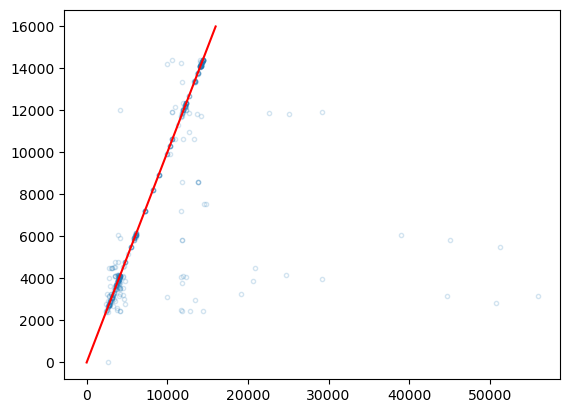

In [38]:
plt.plot(preds.predictions.argmax(axis=-1), preds.label_ids, '.', alpha = .2, fillstyle = 'none')
plt.plot([0, 16000], [0, 16000], 'r-')

In [322]:
trainer.push_to_hub("amirkazemim/distilbert_base_cased_finetuned_products")

CommitInfo(commit_url='https://huggingface.co/amirkazemim/distilbert-base-cased-finetuned-products/commit/4141c89c50f6b08ab95ffd24aa3e507c6327c631', commit_message='amirkazemim/distilbert_base_cased_finetuned_products', commit_description='', oid='4141c89c50f6b08ab95ffd24aa3e507c6327c631', pr_url=None, pr_revision=None, pr_num=None)

In [323]:
unq_ids, unq_cnt = np.unique(preds.label_ids, return_counts=True)
pred_labs = preds.predictions.argmax(axis=-1)

In [324]:
unq_ids[0], unq_cnt[0]

(22050, 2)

In [326]:
for ii, (iu, uc) in enumerate(zip(unq_ids, unq_cnt)):
    pred_sel = pred_labs[np.where(preds.label_ids == iu)[0]]
    prc_u = np.sum(pred_sel == iu)
    if uc>1:
        print(f'{ii}-{iu}: {uc}, {prc_u}, {prc_u/uc:.2f}')

0-22050: 2, 0, 0.00
2-22295: 4, 3, 0.75
3-22344: 2, 2, 1.00
4-22393: 2, 0, 0.00
5-22442: 2, 1, 0.50
6-22540: 5, 2, 0.40
8-22638: 2, 1, 0.50
9-22687: 2, 2, 1.00
10-22736: 3, 0, 0.00
13-22883: 2, 1, 0.50
18-23177: 2, 0, 0.00
20-23275: 3, 2, 0.67
22-23471: 4, 2, 0.50
23-23520: 2, 2, 1.00
24-23569: 3, 3, 1.00
26-23667: 7, 6, 0.86
27-23716: 5, 2, 0.40
29-24108: 4, 0, 0.00
31-24353: 2, 2, 1.00
33-25039: 4, 1, 0.25
34-25431: 3, 3, 1.00
35-25529: 2, 2, 1.00
38-25676: 4, 2, 0.50
40-25774: 2, 2, 1.00
41-26754: 4, 4, 1.00
43-27783: 2, 2, 1.00
44-28126: 3, 0, 0.00
45-28469: 4, 4, 1.00
46-28812: 2, 1, 0.50
47-29204: 2, 0, 0.00
48-29253: 2, 2, 1.00
49-29302: 4, 4, 1.00
50-29547: 2, 2, 1.00
51-29645: 5, 4, 0.80
53-29743: 3, 2, 0.67
54-29841: 3, 3, 1.00
55-29890: 2, 2, 1.00
57-30086: 4, 2, 0.50
58-30135: 2, 1, 0.50
59-30184: 9, 4, 0.44
61-30968: 2, 2, 1.00
62-31017: 2, 2, 1.00
64-31213: 2, 1, 0.50
65-31311: 3, 2, 0.67
66-31360: 2, 1, 0.50
67-31409: 7, 0, 0.00
68-31458: 3, 0, 0.00
69-31507: 5, 3, 0.60


In [100]:
ii=67
iu, uc = unq_ids[ii], unq_cnt[ii]
pred_sel = pred_labs[np.where(preds.label_ids == iu)[0]]
prc_u = np.sum(pred_sel == iu)
print(pred_sel)
if uc>10:
    print(f'{iu}: {uc}, {prc_u}, {prc_u/uc:.2f}')

[9469 9469 9943 9469 9737 9469 9469 9932 9929 9943 9943 9470 9666 9932
 9943 9932 9469 9932 9943 9943 9469 9929 9943 9943 9943 9469 9469 9469
 9469 9933 9943 9943 9943 9943 9943 9943 9943 9929 9469 9943 9943 9929
 9943 9943 9929 9943 9469 9469 9469 9929 9469 9469 9469 9943 9929 9929
 9469 9469 9943 9943 9737 9469 9943 9470 9470 9535 9667 9932 9943 9666
 9943 9667 9943 9469 9929 9929 9943 9943 9943 9996 9932 9535]
9469: 82, 22, 0.27


In [78]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

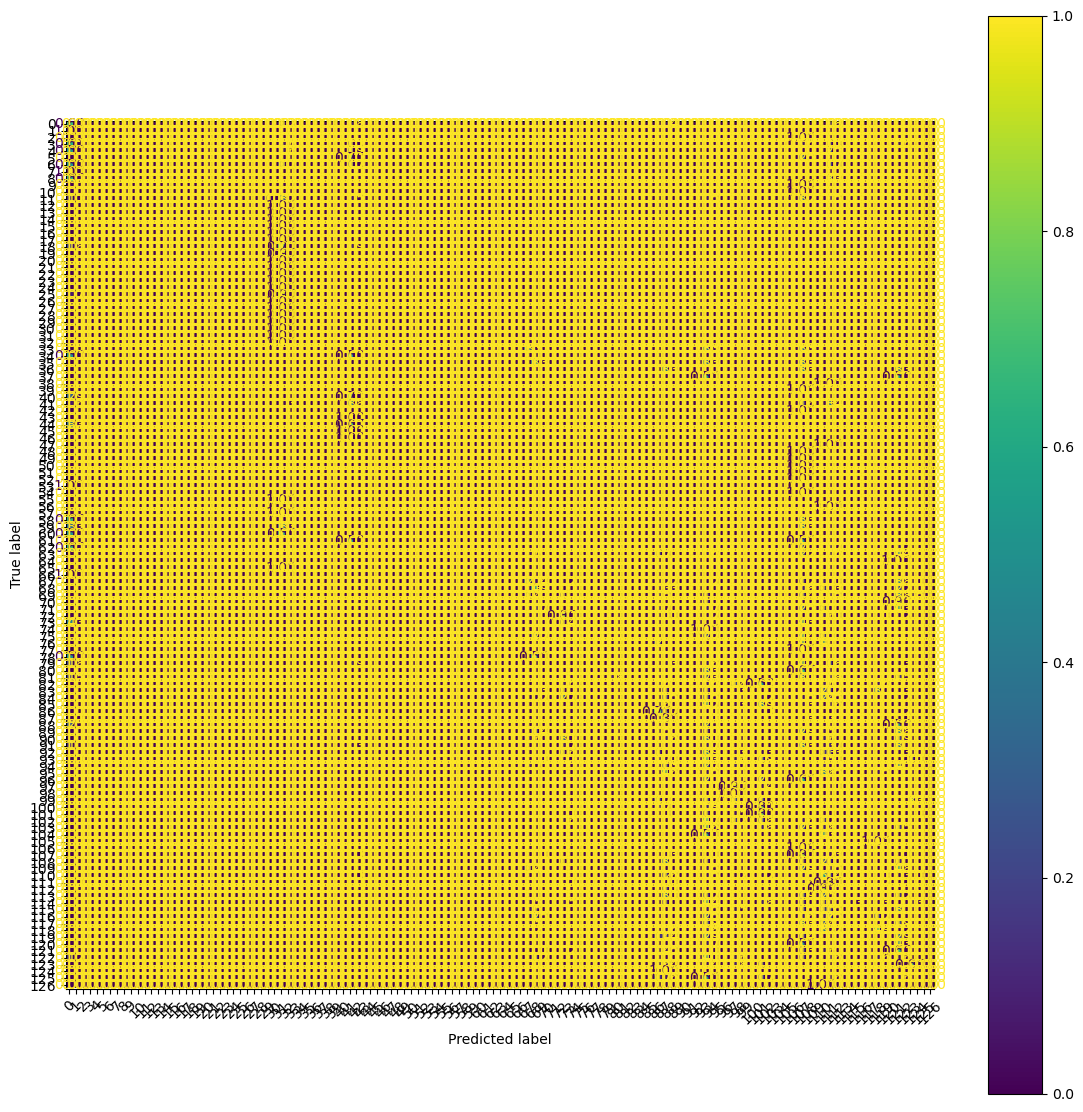

In [79]:
fig, ax = plt.subplots(figsize=(14, 14)) 

cm = confusion_matrix(y_true=preds.label_ids, y_pred=preds.predictions.argmax(axis=-1), normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(ax=ax, cmap='viridis', xticks_rotation=45, values_format='.2f') 


In [352]:
for ids in range(len(prod_encoded['test'])):
    print(prod_encoded['test'][ids]['label'], classifier(prod_encoded['test'][ids]['text'])[0]['label'])

65 LABEL_65
65 LABEL_68
65 LABEL_65
65 LABEL_268
65 LABEL_65
65 LABEL_65
65 LABEL_65
65 LABEL_65
65 LABEL_68
65 LABEL_65
65 LABEL_65
65 LABEL_68
65 LABEL_68
65 LABEL_65
65 LABEL_68
65 LABEL_65
65 LABEL_65
66 LABEL_65
66 LABEL_65
65 LABEL_68
65 LABEL_65
65 LABEL_215
65 LABEL_68
65 LABEL_215
65 LABEL_68
65 LABEL_65
65 LABEL_268
65 LABEL_268
65 LABEL_65
65 LABEL_65
65 LABEL_65
65 LABEL_68
65 LABEL_65
65 LABEL_65
65 LABEL_65
65 LABEL_65
65 LABEL_68
65 LABEL_65
65 LABEL_65
65 LABEL_270
68 LABEL_68
68 LABEL_68
68 LABEL_68
68 LABEL_68
68 LABEL_68
68 LABEL_65
68 LABEL_68
68 LABEL_68
68 LABEL_68
68 LABEL_65
68 LABEL_68
68 LABEL_68
68 LABEL_68
68 LABEL_65
68 LABEL_68
68 LABEL_68
68 LABEL_68
68 LABEL_68
68 LABEL_65
68 LABEL_68
68 LABEL_68
68 LABEL_68
68 LABEL_68
71 LABEL_65
71 LABEL_65
71 LABEL_65
71 LABEL_65
71 LABEL_65
71 LABEL_68
67 LABEL_68
69 LABEL_68
69 LABEL_68
69 LABEL_69
69 LABEL_65
69 LABEL_65
69 LABEL_65
69 LABEL_65
69 LABEL_69
69 LABEL_65
69 LABEL_68
69 LABEL_65
69 LABEL_268
69 LABEL_

KeyboardInterrupt: 